# Visualize training of static VAE on circle/Gaussian data


### training parameters
- Input: circles on Gaussian-blob background (32x32)

- Number of latents: 4

- batch size: 64

- 500K training samples
- RMSprop w lr = 1e-04


Beta VAE:
- six different normalized beta Values (sampling roughly corresponding to Higgins 2017 y-axis):


``` normalized_beta_values = np.logspace(np.log(.001), np.log(5), 6, base=np.e) ```


In [91]:
import torch
import pickle
from models import staticVAE32, beta_from_normalized_beta

from torchvision import transforms

import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append("..") # Adds higher directory to python modules path.
from data.dspritesb import dSpriteBackgroundDataset

In [92]:
normalized_beta_values = np.logspace(np.log(.001), np.log(5), 6, base=np.e)
normalized_beta_values = normalized_beta_values

In [93]:
vae = list()
training_stats = list()
for ii,beta_norm in enumerate(normalized_beta_values):

    beta_norm_str = '%0.4f' % (beta_norm)
    if beta_norm_str[-1] == '0':
        beta_norm_str = beta_norm_str[:-1]
    
    trainedpath = 'trained/staticvae32_betanorm=%s_dsprites_circle_last_500K' % (beta_norm_str)
    trainstatspath = 'trained/staticvae32_betanorm=%s_dsprites_circle_500K.pkl' % (beta_norm_str)
    
    vae.append(staticVAE32(n_latent = 4))
    checkpoint = torch.load(trainedpath)
    vae[ii].load_state_dict(checkpoint['model_states']['net'])

    training_stats.append(pickle.load(open(trainstatspath, 'rb')))


FileNotFoundError: [Errno 2] No such file or directory: 'trained/staticvae32_betanorm=0.001_dsprites_circle_last_500K'

In [48]:
N = vae[0].img_channels * 32 * 32
M = vae[0].n_latent

beta = beta_from_normalized_beta(normalized_beta_values, N = N, M = M)

### plot training loss

Three different plots:

- loss = recon_loss + beta * kl_div
- recon_loss
- kl_div

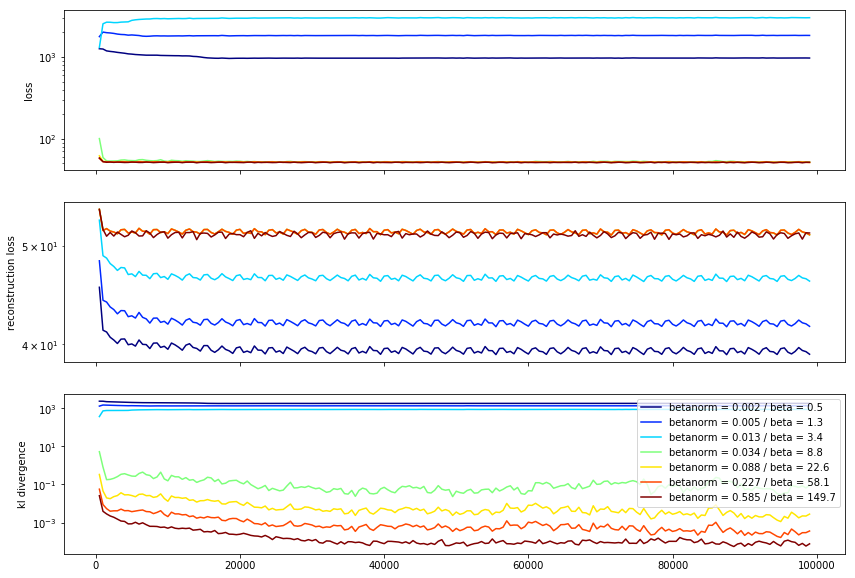

In [64]:
show_until_nth_batch = 100000
idx_lim = np.max(np.where(np.array(training_stats[ii]['iter']) < show_until_nth_batch))

fig, ax = plt.subplots(3,1,sharey=False,sharex=True, figsize=(14,10))
ax = ax.flatten()

col = plt.cm.jet(np.linspace(0,1,len(normalized_beta_values)))
for ii,nb in enumerate(normalized_beta_values):
    logged_steps = training_stats[ii]['iter'][:idx_lim]
    recon_loss = np.array(training_stats[ii]['recon_loss'][:idx_lim])
    total_kld = np.array(training_stats[ii]['total_kld'][:idx_lim])
    
    ax[0].plot(logged_steps, recon_loss+ beta[ii] * total_kld, color=col[ii])
    ax[1].plot(logged_steps, recon_loss, color=col[ii])
    ax[2].plot(logged_steps, total_kld, color=col[ii])
    
    ax[0].set(ylabel='loss')
    ax[1].set(ylabel='reconstruction loss')    
    ax[2].set(ylabel='kl divergence')
    
    _ = [x.set(yscale='log') for x in ax]
    
    ax[2].legend(['betanorm = %0.3f / beta = %0.1f' % (x,y) for x,y in zip(normalized_beta_values,beta)], loc=1)


## load some data and plot reconstructions


In [69]:
ds = dSpriteBackgroundDataset(transform=transforms.Resize(32),shapetype = 'circle')

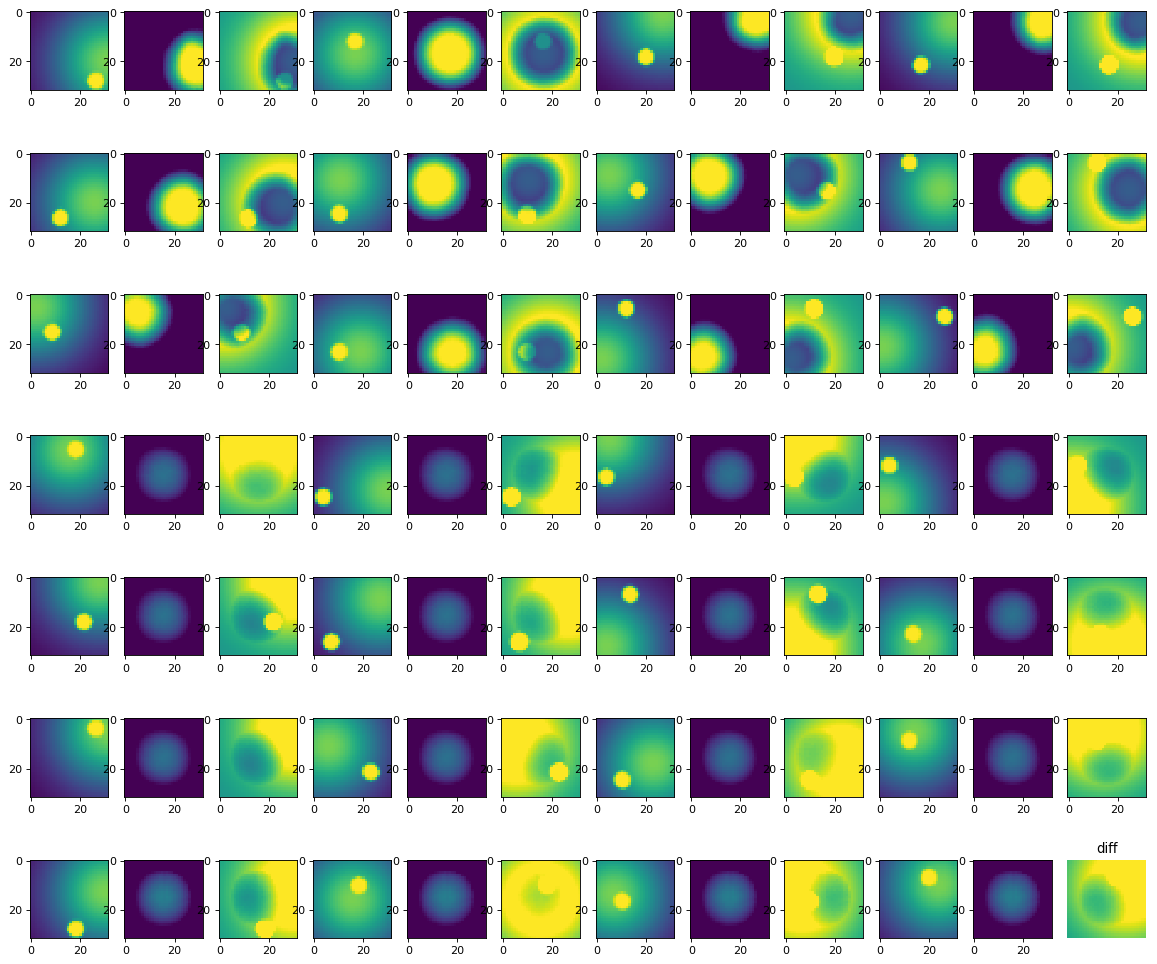

In [75]:
fig, ax = plt.subplots(len(vae),12,figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
ax = ax.flatten()
cnt = -1
for jj,nb in enumerate(normalized_beta_values):
    for ii in range(4):
        x,label = ds[np.random.randint(1000)]
        x = x[np.newaxis, :, :]

        mu, logvar = vae[jj].encode(x.float())
        recon = vae[jj].decode(mu).detach()
        diff = x - recon

        cnt += 1
        ax[cnt].imshow(x.squeeze(), vmin=0, vmax=1)
        plt.title('true')
        plt.axis('off')

        cnt += 1
        ax[cnt].imshow(recon.squeeze(), vmin=0, vmax=1)
        plt.title('recon')
        plt.axis('off')

        cnt += 1
        m = .5
        img = ax[cnt].imshow(diff.numpy().squeeze(), vmin=-m, vmax=m)
        #fig.colorbar(img)
        plt.title('diff')
        plt.axis('off')

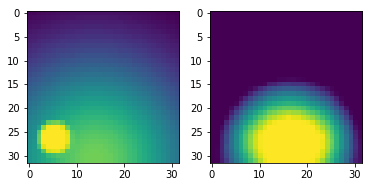

In [90]:
_,ax = plt.subplots(1,2)
trsmp = 800
ax[0].imshow(training_stats[1]['target'][trsmp].squeeze())
ax[1].imshow(training_stats[1]['reconstructed'][trsmp].squeeze())